### Imports modules needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import time
from scipy.optimize import curve_fit

### Reads the csv data and adds new columns containing the week and month of each row


In [138]:
df = pd.read_csv("temp_datalab_records_linkedin_company.csv",low_memory=False)
df["as_of_date"] = pd.to_datetime(df["as_of_date"],format="%Y-%m-%d")
df['day_of_week'] = df['as_of_date'].apply(lambda x: x.weekday()) # get the weekday index
df['day_of_week'] = df['day_of_week'].apply(lambda x: calendar.day_name[x])
df['month'] = df.as_of_date.dt.month


### Get change in likes where two successive dates are consencutive.

In [139]:

def get_change_in_likes(df):
    if df.empty:
        return(df)
    #converts dates to ordinal for easy computation
    df['ordinal_date'] = df['as_of_date'].apply(lambda x: x.toordinal())
    df["day_difference"] = np.nan
    df["like_difference"] = np.nan
    df["employees_on_platform_difference"] = np.nan
    row_iterator = df.iterrows()
    try:
        _, row = next(row_iterator)  # take first item from row_iterator
    except StopIteration as e:
        return(None)
    for i, _next in row_iterator:
        current_row = row['ordinal_date']
        current_likes = row['followers_count']
        current_employ_likes = row['employees_on_platform']
        
        next_row = _next['ordinal_date']
        next_likes = _next['followers_count']
        next_employ_likes = _next['employees_on_platform']
        current_and_next_low_list = [current_row,next_row]
        row = _next
        #Checks if two neighboring dates are consecutive
        if max(current_and_next_low_list) - min(current_and_next_low_list) == \
        len(current_and_next_low_list) - 1:
            df.loc[i, 'day_difference'] = next_row - current_row
            df.loc[i, "like_difference"] = next_likes - current_likes
            df.loc[i, "employees_on_platform_difference"] = \
            abs(next_employ_likes - current_employ_likes)

        else:
            pass
    # selects rows where day_difference is not null. They satisfy what we want
    df = df[(df["day_difference"].notnull())]
    df = df[(df["like_difference"].notnull())]
    df = df[(df["employees_on_platform_difference"].notnull())]
    return(df)

### Fits and plots the data and quadratic fit

In [ ]:
#Plotting for followers likes per week
plt.rc('font', family='serif')

def quadratic_fit(x,a,b,c):
    return np.array(a+b*x+c*x**2)
groups = df.groupby("company_name")
#company = "Walmart" # put the name of company you want
companies = ["Facebook","Walmart","Google","Amazon","Apple","AT&T","CVS Health","Twitter",\
             "General Motors","UnitedHealth Group","McKesson","ExxonMobil","LinkedIn"]
companies = ["Total","ExxonMobil","BP","Petrobras","Chevron","Halliburton","Schlumberger"]
for company in companies:
    df1 = groups.get_group(company)
    df1 = df1[df1['followers_count']>=1]
    df1 = get_change_in_likes(df1)
    df1 = df1.groupby("day_of_week")
    #get the days and sort them in the right order
    weekdays = df1.groups.keys()
    days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    days_abbrev = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    ordered_weekdays = sorted(weekdays, key=days.index)
    followers_weekly_avg = []
    employees_likes_weekly_avg = []
    for day in ordered_weekdays:
        d = df1.get_group(day)
        mean_following = d.like_difference.mean()
        mean_employ_likes =d.employees_on_platform_difference.mean()
        followers_weekly_avg.append(mean_following)
        employees_likes_weekly_avg.append(mean_employ_likes)
    points = [1,2,3,4,5,6,7] #the days of the week
    P0 = np.array([1,1,1])
    coeffs, matcov = curve_fit(quadratic_fit, points, followers_weekly_avg, P0)
    x = np.linspace(0.5,7,100)
    y = quadratic_fit(x,*coeffs)
    #plots the data
    plt.plot(points,followers_weekly_avg,"k*",x,y,"r")
    plt.xticks(points, days_abbrev)
    plt.title("Quadratic fit to "+company+" LinkedIn page likes",size=12,weight ='bold')
    plt.xlabel("day of the week",size=8,weight ='bold')
    plt.ylabel("Average number of new LinkedIn likes",size=8,weight ='bold')
    plt.legend(["Data","Fit"])
    plt.xticks(rotation=90)
    plt.savefig(company+".png",bbox_inches="tight", dpi=1000)
    plt.show()

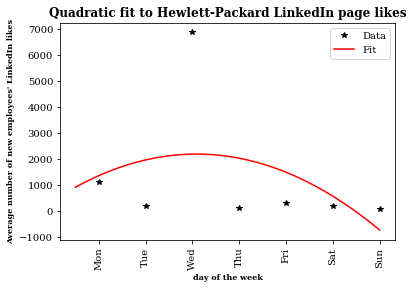

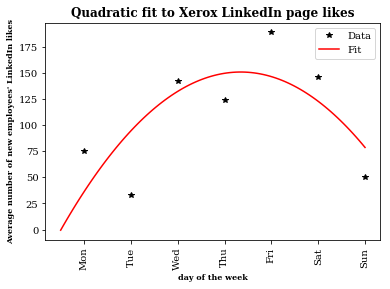

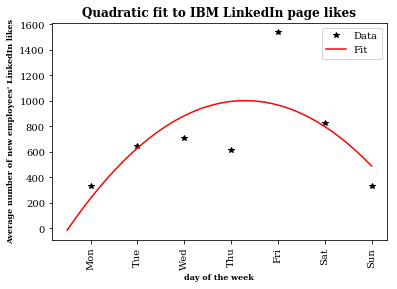

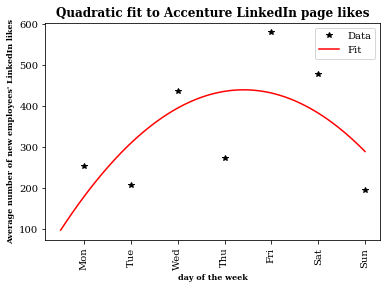

In [204]:
# plots for Employess likes
plt.rc('font', family='serif')

def quadratic_fit(x,a,b,c):
    return np.array(a+b*x+c*x**2)
groups = df.groupby("company_name")
#company = "Walmart" # put the name of company you want
companies = ["Facebook","Walmart","Google","Amazon","Apple","AT&T","CVS Health","Twitter",\
#             "General Motors","UnitedHealth Group","McKesson","ExxonMobil","LinkedIn"]
#companies = ["Hewlett-Packard","Xerox","IBM","Accenture"]
for company in companies:
    df1 = groups.get_group(company)
    df1 = df1[df1['employees_on_platform']>=1]
    df1 = get_change_in_likes(df1)
    df1 = df1.groupby("day_of_week")
    #get the days and sort them in the right order
    weekdays = df1.groups.keys()
    days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    days_abbrev = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    ordered_weekdays = sorted(weekdays, key=days.index)
    followers_weekly_avg = []
    employees_likes_weekly_avg = []
    for day in ordered_weekdays:
        d = df1.get_group(day)
        mean_following = d.like_difference.mean()
        mean_employ_likes =d.employees_on_platform_difference.mean()
        followers_weekly_avg.append(mean_following)
        employees_likes_weekly_avg.append(mean_employ_likes)
    points = [1,2,3,4,5,6,7] #the days of the week
    P0 = np.array([1,1,1])
    coeffs, matcov = curve_fit(quadratic_fit, points, employees_likes_weekly_avg, P0) # employees' likes
    x = np.linspace(0.5,7,100)
    y = quadratic_fit(x,*coeffs)
    #plots the data
    plt.plot(points,employees_likes_weekly_avg,"k*",x,y,"r") # for employees' likes
    plt.xticks(points, days_abbrev)
    plt.title("Quadratic fit to "+company+" LinkedIn page likes",size=12,weight ='bold')
    plt.xlabel("day of the week",size=8,weight ='bold')
    plt.ylabel("Average number of new employees' LinkedIn likes",size=8,weight ='bold') # for employees' likes
    plt.legend(["Data","Fit"])
    plt.xticks(rotation=90)
    plt.savefig(company+".png",bbox_inches="tight", dpi=1000)
    plt.show()